# FT-Transformer Model

In [18]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [21]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Data Preprocessing

In [22]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [23]:
features_df

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0,1,0,0,0,0,1,0,0.475269,0.683419
99996,0.666667,0,0,0,0,0,0,1,0,0.562420,0.861997
99997,0.666667,0,1,0,0,0,0,1,0,0.225903,0.243447
99998,0.333333,0,1,1,0,0,0,0,0,0.073531,0.058008


In [24]:
num_cols = features_df.columns.tolist()
num_cols

['yeojohnson_revenue_in_eur_bin',
 'is_EMEA',
 'is_Webshop',
 'is_industry_FinanceInsuranceRealEstate',
 'is_industry_Manufacturing',
 'is_industry_Other',
 'is_industry_RetailTrade',
 'is_industry_Services',
 'is_industry_WholesaleTrade',
 'license_value_score',
 'customer_value_score']

In [25]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 1   is_EMEA                                 100000 non-null  int64  
 2   is_Webshop                              100000 non-null  int64  
 3   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 4   is_industry_Manufacturing               100000 non-null  int64  
 5   is_industry_Other                       100000 non-null  int64  
 6   is_industry_RetailTrade                 100000 non-null  int64  
 7   is_industry_Services                    100000 non-null  int64  
 8   is_industry_WholesaleTrade              100000 non-null  int64  
 9   license_value_score                     100000 non-null  float64
 10  customer_value_score                    10000

## Feature-Tokenizer Transformer (FT-Transformer) Model

In [26]:
class TabularDataset(Dataset):
    def __init__(self, df, num_cols=None):
        #self.cat_cols = cat_cols if cat_cols else []
        self.num_cols = num_cols if num_cols else []
        #self.cat_data = df[self.cat_cols].values if self.cat_cols else None
        self.num_data = df[self.num_cols].values if self.num_cols else None
        
    def __len__(self):
        return len(df)
    
    def __getitem__(self, idx):
        #cat_feats = torch.tensor(self.cat_data[idx], dtype=torch.long) if self.cat_cols else None
        num_feats = torch.tensor(self.num_data[idx], dtype=torch.float) if self.num_cols else None
        return num_feats

In [27]:
# Example usage of the Dataset class
dataset = TabularDataset(features_df, num_cols=num_cols)

# DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [28]:
# Define FTTransformer model
class FTTransformer(nn.Module):
    def __init__(self, num_categorical_features, num_numerical_features, cat_vocab_size, cat_embed_dim, num_heads, num_layers, d_model, hidden_dim, dropout):
        super(FTTransformer, self).__init__()
        
        if num_categorical_features > 0:
            # Embedding layers for categorical features
            self.cat_embed_layers = nn.ModuleList([
                nn.Embedding(num_embeddings=cat_vocab_size, embedding_dim=cat_embed_dim) for _ in range(num_categorical_features)
            ])
        else:
            self.cat_embed_layers = None
        
        if num_numerical_features > 0:
            # Linear layer for numerical features
            self.num_linear_layer = nn.Linear(num_numerical_features, d_model)
        else:
            self.num_linear_layer = None
        
        if num_categorical_features > 0 or num_numerical_features > 0:
            # Transformer Encoder
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("At least one of num_categorical_features or num_numerical_features must be greater than 0.")
        
        # Output layer for CLS token representation (not used in clustering)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Learnable parameter for CLS token
    
    def forward(self, cat_feats=None, num_feats=None):
        if self.cat_embed_layers and cat_feats is not None:
            # Embed categorical features
            cat_embeds = [embed(cat_feats[:, i]) for i, embed in enumerate(self.cat_embed_layers)]
            cat_embeds = torch.cat(cat_embeds, dim=-1)
        else:
            cat_embeds = torch.tensor([], dtype=torch.float).to(cat_feats.device) if cat_feats is not None else None
        
        if self.num_linear_layer and num_feats is not None:
            # Linear transformation of numerical features
            num_embeds = self.num_linear_layer(num_feats)
        else:
            num_embeds = torch.tensor([], dtype=torch.float).to(num_feats.device) if num_feats is not None else None
        
        if cat_embeds is not None and num_embeds is not None:
            # Combine embeddings
            combined_embeds = torch.cat([cat_embeds, num_embeds], dim=-1)
        elif cat_embeds is not None:
            combined_embeds = cat_embeds
        elif num_embeds is not None:
            combined_embeds = num_embeds
        else:
            raise ValueError("At least one of cat_feats or num_feats must not be None.")
        
        # Add positional encoding if needed
        combined_embeds = combined_embeds.unsqueeze(1)  # (batch_size, seq_len=1, d_model)
        
        # Transformer encoding
        encoded_output = self.transformer_encoder(combined_embeds)
        
        return encoded_output.squeeze(1)  # Return the encoded output for clustering

In [29]:
# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss, model):
        if self.best_loss is None:
            self.best_loss = loss
            self.save_checkpoint(model)
        elif loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.path))

In [30]:
# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Instantiate the model and move it to the appropriate device
model = FTTransformer(num_categorical_features=0,  # No categorical features
                      num_numerical_features=len(num_cols), 
                      cat_vocab_size=0,  # Not used
                      cat_embed_dim=0,  # Not used
                      num_heads=4,
                      num_layers=2,
                      d_model=32,
                      hidden_dim=64,
                      dropout=0.2
)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)

Using device: cuda


In [31]:
# Training loop with early stopping
num_epochs = 3
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for num_feats in loader:
        num_feats = num_feats.to(device)
        optimizer.zero_grad()
        embeddings = model(num_feats=num_feats)
        # No specific target for clustering, so use a dummy loss
        loss = criterion(embeddings, torch.zeros_like(embeddings))  # Dummy loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * num_feats.size(0)
    train_loss /= len(loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')
    
    # Early stopping based on training loss
    early_stopping(train_loss, model)
    if early_stopping.early_stop:
        print('Early stopping')
        break

Epoch [1/3], Loss: 0.0609
Epoch [2/3], Loss: 0.0000
Epoch [3/3], Loss: 0.0000


In [32]:
# Load best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [33]:
# Example of clustering with embeddings from the best model
model.eval()
embeddings_list = []
with torch.no_grad():
    for num_feats in loader:
        num_feats = num_feats.to(device) if num_feats is not None else None
        embeddings = model(num_feats=num_feats)
        embeddings_list.append(embeddings.cpu().numpy())
embeddings = np.vstack(embeddings_list)

## Determine the number of clusters(k)

In [34]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


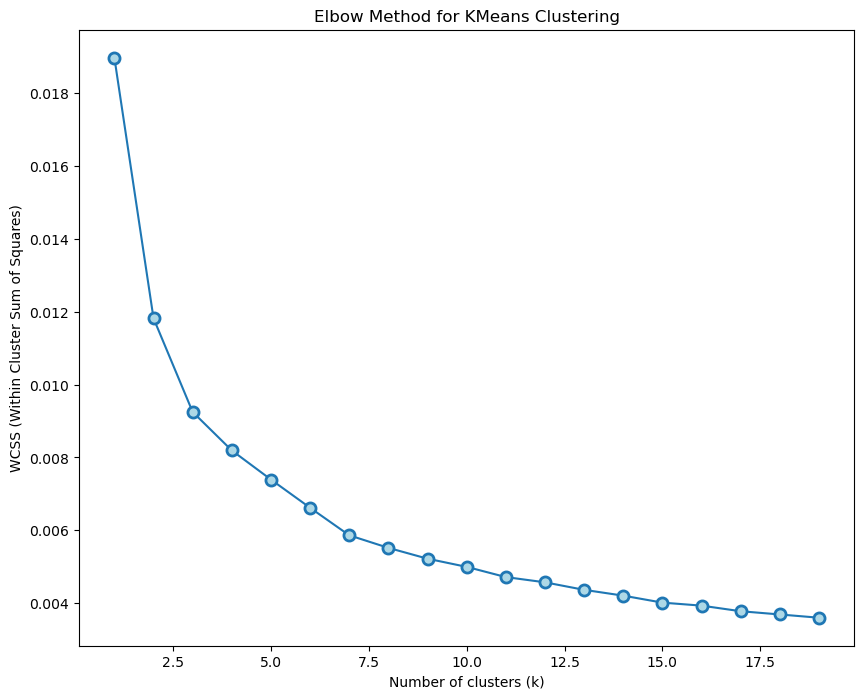

In [35]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [36]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(embeddings)
df.groupby(['cluster_kmeans']).mean()

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.500153,0.755332,0.486659,0.074920,0.135126,0.152975,0.099153,0.437643,0.100183,0.450512,0.403273
1,0.497732,0.761012,0.491121,0.078240,0.136589,0.152964,0.093231,0.443554,0.095422,0.450078,0.404179
2,0.500839,0.756135,0.492196,0.075367,0.135846,0.156202,0.098162,0.434079,0.100344,0.450010,0.405208


In [ ]:
# df.mean()

In [37]:
df.cluster_kmeans.value_counts()

0    43700
2    38956
1    17344
Name: cluster_kmeans, dtype: int64

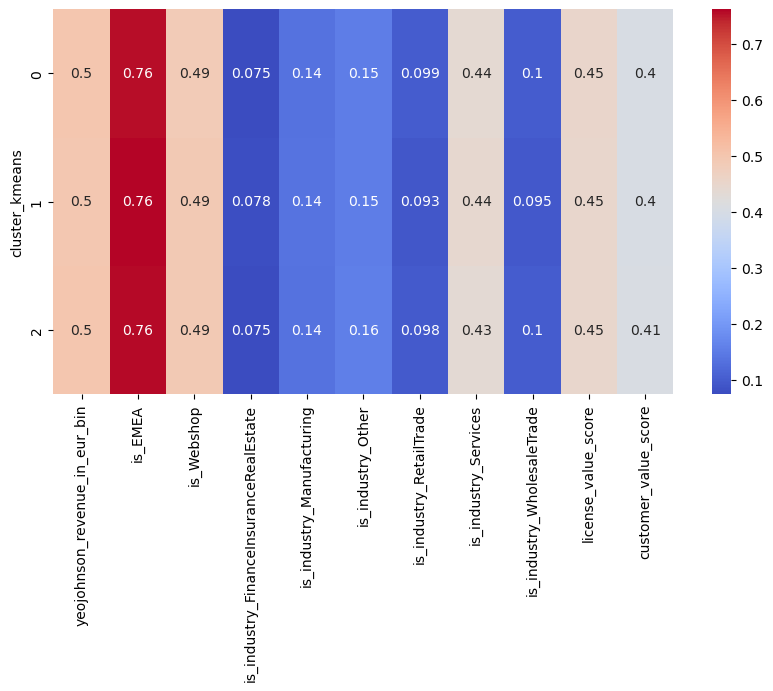

In [38]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [39]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

## Evaluation

In [40]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: -0.001


In [41]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 267.660


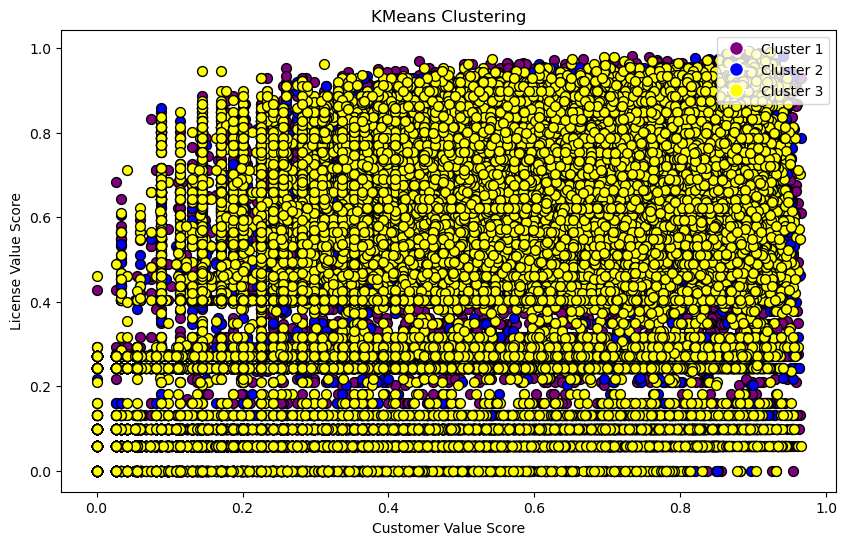

In [42]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()